# Simulate second-order systems

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve, ivpsolvers
from probdiffeq.doc_util import notebook
from probdiffeq.implementations import recipes
from probdiffeq.strategies import filters

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

Quick refresher: first-order ODEs

In [3]:
f, u0, (t0, t1), f_args = ivps.three_body_restricted_first_order()


@jax.jit
def vf_1(y, t, p):
    return f(y, *p)


ts0_1 = ivpsolvers.MLESolver(filters.Filter(recipes.IsoTS0.from_params()))
ts = jnp.linspace(t0, t1, endpoint=True, num=500)

In [4]:
%%time

solution = ivpsolve.solve_and_save_at(
    vf_1,
    initial_values=(u0,),
    save_at=ts,
    solver=ts0_1,
    atol=1e-5,
    rtol=1e-5,
    parameters=f_args,
)

CPU times: user 3.94 s, sys: 69.2 ms, total: 4.01 s
Wall time: 3.61 s


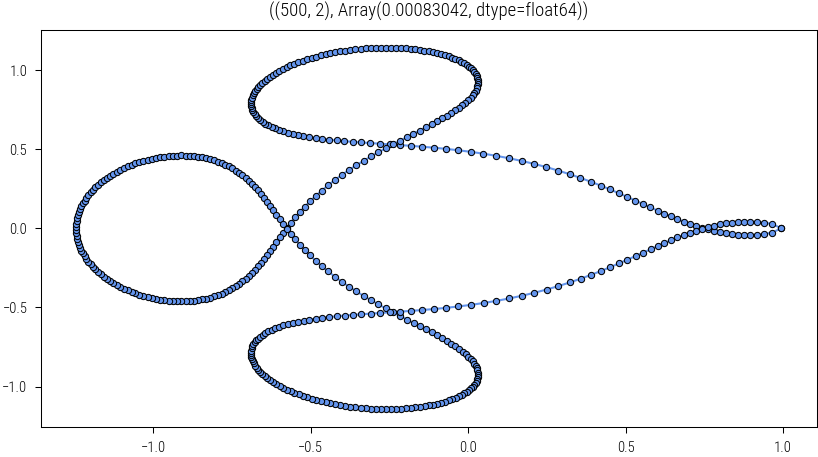

In [10]:
plt.title((solution.u.shape, jnp.linalg.norm(solution.u[-1, ...] - u0)))
plt.plot(solution.u[:, 0], solution.u[:, 1], marker=".")
plt.show()

The default configuration assumes that the ODE to be solved is of first order.
In fact, above, we used the following solver:


In [6]:
implementation = recipes.IsoTS0.from_params(ode_order=1, num_derivatives=4)
ts0_1_granular = ivpsolvers.MLESolver(filters.Filter(implementation))
assert ts0_1_granular == ts0_1

Now, the same game with a second-order ODE

In [7]:
f, (u0, du0), (t0, t1), f_args = ivps.three_body_restricted()


@jax.jit
def vf_2(y, dy, t, p):
    return f(y, dy, *p)


# One derivative more than above because we don't transform to first order
implementation = recipes.IsoTS0.from_params(ode_order=2, num_derivatives=5)
ts0_2 = ivpsolvers.MLESolver(filters.Filter(implementation))
ts = jnp.linspace(t0, t1, endpoint=True, num=500)

In [8]:
%%time

solution = ivpsolve.solve_and_save_at(
    vf_2,
    initial_values=(u0, du0),
    save_at=ts,
    solver=ts0_2,
    atol=1e-5,
    rtol=1e-5,
    parameters=f_args,
)

CPU times: user 3.48 s, sys: 44.5 ms, total: 3.52 s
Wall time: 3.17 s


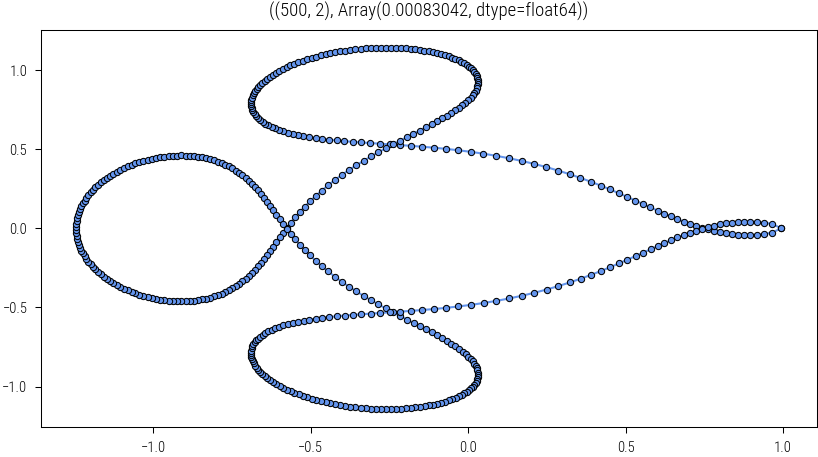

In [11]:
plt.title((solution.u.shape, jnp.linalg.norm(solution.u[-1, ...] - u0)))
plt.plot(solution.u[:, 0], solution.u[:, 1], marker=".")
plt.show()

The results are indistinguishable from the plot. While the runtimes of both solvers are similar, the error of the second-order solver is much lower. 

See the benchmarks for more quantitative versions of this statement.